Carga de los datos


In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_excel('Time_Serie.xlsx') # Serie ya deflactada

df.set_index('Quarter',inplace=True)
df.index=pd.to_datetime(df.index)

Saving Time_Serie.xlsx to Time_Serie.xlsx


#Sliding Window

In [ ]:
!pip install sktime
!pip install pmdarima

In [ ]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
import numpy as np
import seaborn as sns
from warnings import simplefilter
from matplotlib.ticker import MaxNLocator

In [ ]:
def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels);

In [ ]:
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

Variables Exógenas


Variables Oferta y Demanda

Oferta:
  - Numero Hipotecas
  - Numero Visados de Obra (Vlc)

Demanda:
  - Poblacion Activa (Vlc)
  - Euribor
  - Salarios (Renta)

In [ ]:
df_ind = df_ind.drop(67) # Eliminamos la última fila porque no tiene datos

exog = np.empty([67,5])

for i in range(len(df_ind)):
  exog[i,0] = df_ind['Numero Hipotecas'][i]
  exog[i,1] = df_ind['Precio Hipotecas'][i]
  exog[i,2] = df_ind['Poblacion Activa'][i]
  exog[i,3] = df_ind['Euribor'][i]
  exog[i,4] = df_ind['Salario Medio'][i]

#Desarrollo modelo ARIMAX

In [ ]:
from sklearn.metrics import mean_squared_error

Number of Folds = 13


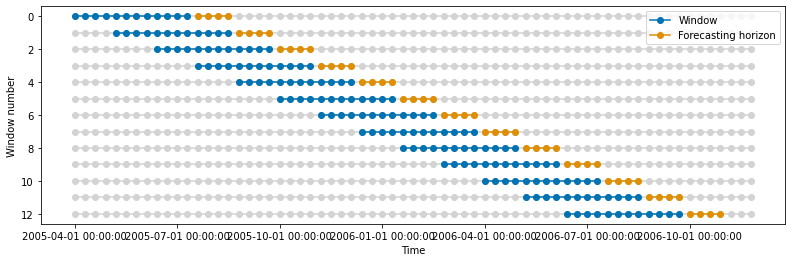

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Prueba para visualizar la técnica de ventana deslizante

cv = SlidingWindowSplitter(window_length=12, fh=[1, 2, 3, 4], step_length = 4)

n_splits = cv.get_n_splits(df)
print(f"Number of Folds = {n_splits}")

train_windows, test_windows = get_windows(df, cv)

plot_windows(df, train_windows, test_windows)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Prueba funcionamiento modelo

indexes_train = list(train_windows[0])
indexes_test = list(test_windows[0])
  
df_train = df.iloc[indexes_train]
df_train = df_train.reset_index(drop = True)
df_test = df.iloc[indexes_test]

exog_train = scaled_exog[indexes_train]
exog_test = scaled_exog[indexes_test]

model = ARIMA(df_train.Precio, order=(1,0,2), exog = exog_train)
model_fit = model.fit()
predictions = model_fit.predict(start = 12, end = 15, exog = exog_test) 
error = np.sqrt(mean_squared_error(df_test.Precio, predictions))
print(error)

In [ ]:
def Window_fitter(p,d,q): # Función para entrenar modelo y obtener error medio
  total = 0
  warnings.filterwarnings('ignore')
  cv = SlidingWindowSplitter(window_length = 4, fh= [1,2,3,4])
  train_windows, test_windows = get_windows(df, cv)
  rmse = []
  for i in range(len(train_windows)):
    indexes_train = list(train_windows[i])
    indexes_test = list(test_windows[i])
      
    df_train = df.iloc[indexes_train]
    df_train = df_train.reset_index(drop = True) # Necesario Resetear índice para no tener problemas luego con los índices temporales
    df_test = df.iloc[indexes_test]

    exog_train = scaled_exog[indexes_train]
    exog_test = scaled_exog[indexes_test]
    try:
      model = ARIMA(df_train.Precio, order=(p,d,q), exog = exog_train)
      model_fit = model.fit()
      predictions = model_fit.predict(start = 4, end = 7, exog = exog_test) 
      error = np.sqrt(mean_squared_error(df_test.Precio, predictions))
      rmse.append(error)
    except: pass

  return ((p,d,q), np.mean(rmse))



#Horizonte temporal 4Q

Longitud de venatana 12

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(1,3)
w_l = 12
h = [1,2,3,4]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)
      
best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 16

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(1,3)
w_l = 16
h = [1,2,3,4]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 8

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(1,3)
w_l = 8
h = [1,2,3,4]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 20

In [ ]:
p_values = [0,1,2,3,4,5]
q_values = [0,1,2,3,5]
d_values = range(1,3)
w_l = 20
h = [1,2,3,4]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 24

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(1,3)
w_l = 24
h = [1,2,3,4]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

#HORIZONTE TEMPORAL 2 Q 

Longitud de venatana 12

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(1,3)
w_l = 12
h = [1,2]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 16

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(1,3)
w_l = 16
h = [1,2]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)


best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 8

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(1,3)
w_l = 8
h = [1,2]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)


best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 20

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(1,3)
w_l = 20
h = [1,2]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 24

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(1,3)
w_l = 24
h = [1,2]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

#HORIZONTE TEMPORAL 8Q

Longitud de venatana 12

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(0,3)
w_l = 12
h = [1,2,3,4,5,6,7,8]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 16

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(0,3)
w_l = 16
h = [1,2,3,4,5,6,7,8]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 8

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(0,3)
w_l = 8
h = [1,2,3,4,5,6,7,8]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 20

In [ ]:
p_values = [0,1,2,3,4,5]
q_values = [0,1,2,3,5]
d_values = range(0,3)
w_l = 20
h = [1,2,3,4,5,6,7,8]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)

Longitud de venatana 24

In [ ]:
p_values = [0,1,2,3,4,5] 
q_values = [0,1,2,3,5]
d_values = range(0,3)
w_l = 24
h = [1,2,3,4,5,6,7,8]

results = {}
for p in p_values:
  for q in q_values:
    for d in d_values:
      order = (p,d,q)
      result = Window_fitter(p,d,q)
      results[order] = result
      #print(order, result)

best = 10000
for comb in results:
  rmse = results[comb]
  if rmse < best: best = rmse
  else: pass
print(best)